# Set System Path

In [13]:
import sys
import os

sys_path = os.path.dirname(os.getcwd())
print(sys_path)
sys.path.append(sys_path)
os.chdir(sys_path)

/Users/shikaiyi/Desktop/Ncku/MedicalImage/final


# Segment Blood Vessels

In [14]:
import cv2
from retina_features.bloodvessels import extract_bv

In [15]:
pathFolder = "data/Sample_imgs/TV"
filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
destinationFolder = "data/Sample_imgs/TV_processed/"

In [16]:
for file_name in filesArray:
    file_name_no_extension = os.path.splitext(file_name)[0]
    fundus = cv2.imread(pathFolder + '/' + file_name)		
    bloodvessel = extract_bv(fundus)
    cv2.imwrite(destinationFolder + file_name_no_extension + "_bloodvessel.png", bloodvessel)

- 看起來 907 & 1329 最明顯（？
- 用 907 好了

# Circle TV Points By Curvature Threshold

In [17]:
import numpy as np
from skimage.measure import label
from skimage.color import label2rgb
from skimage import io, morphology, filters

from common import plot_image, compare_plots
from tv_processer import TVProcesser

In [18]:
image_path = 'data/Sample_imgs/TV_processed/907_bloodvessel.png'
vessels_image = io.imread(image_path, as_gray=True)

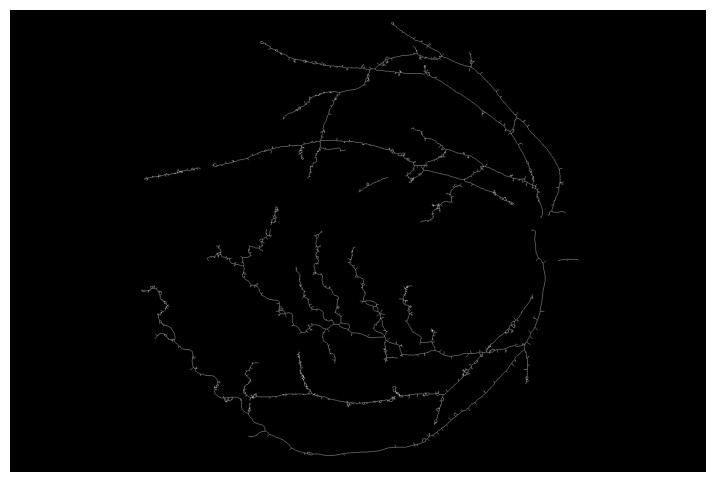

In [19]:
# Binarize the image (assuming the vessels are darker than the background)
# We invert the image because for the skeletonization, we need the vessels in white
binarized_image = vessels_image < np.mean(vessels_image)
skeleton = morphology.skeletonize(binarized_image)
plot_image(skeleton)

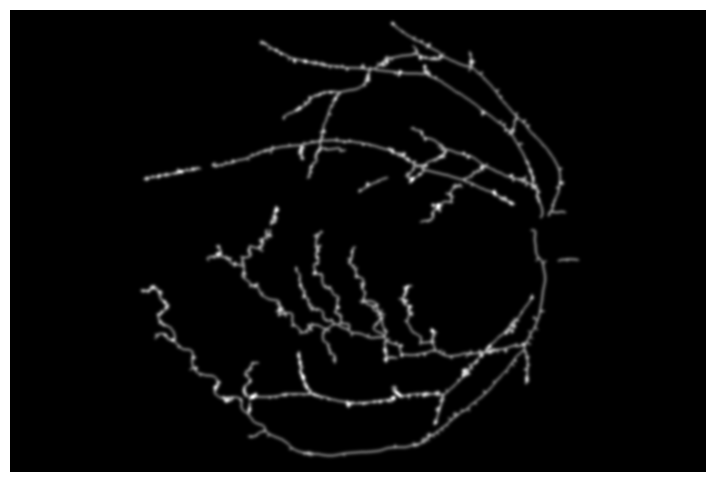

In [20]:
blurred_skeleton = filters.gaussian(skeleton, sigma=5)
plot_image(blurred_skeleton)

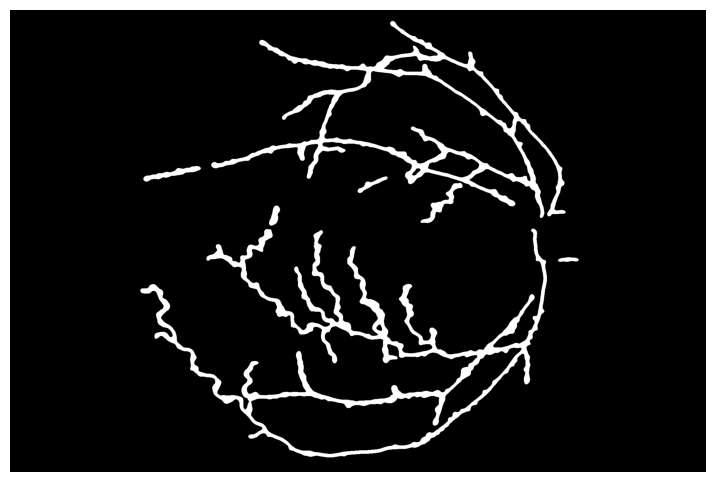

In [21]:
re_threshold_value = filters.threshold_otsu(blurred_skeleton)
re_binarized_skeleton = blurred_skeleton > re_threshold_value
plot_image(re_binarized_skeleton)

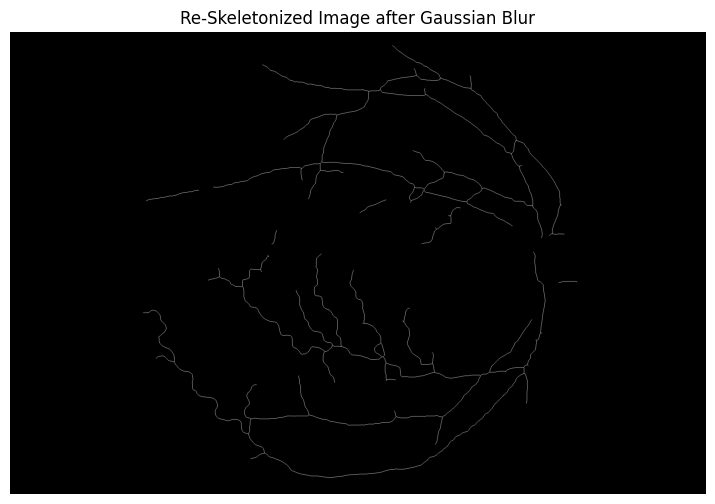

In [22]:
re_skeleton = morphology.skeletonize(re_binarized_skeleton)
plot_image(re_skeleton, "Re-Skeletonized Image after Gaussian Blur")

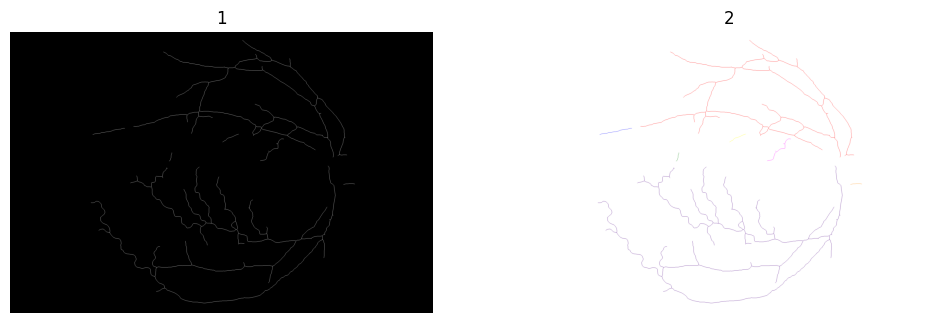

In [23]:
labeled_skeleton = label(re_skeleton)
label_colors = label2rgb(labeled_skeleton, bg_label=0, bg_color=(1, 1, 1))

# Plot the original skeleton and the colored labeled image
compare_plots(re_skeleton, label_colors)

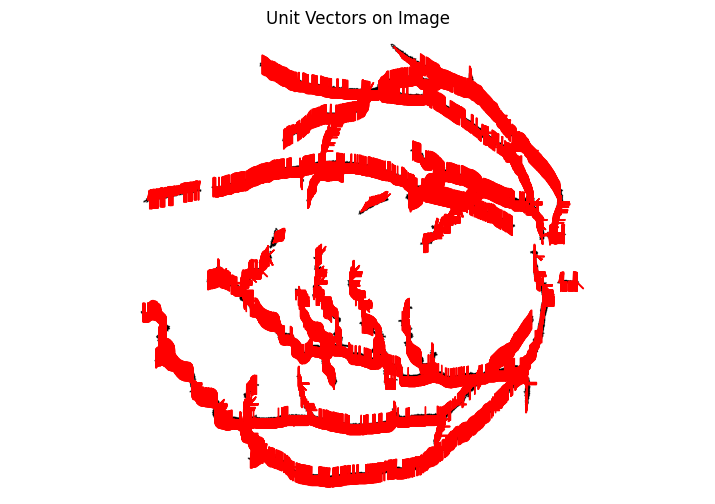

In [24]:
tv_processer = TVProcesser(vessels_image)
unit_vectors = tv_processer.get_unit_vectors(re_skeleton, 5)
tv_processer.plot_unit_vectors(unit_vectors, 30, 0.001)

Marking points: 100%|██████████| 1139/1139 [00:00<00:00, 42798.64it/s]


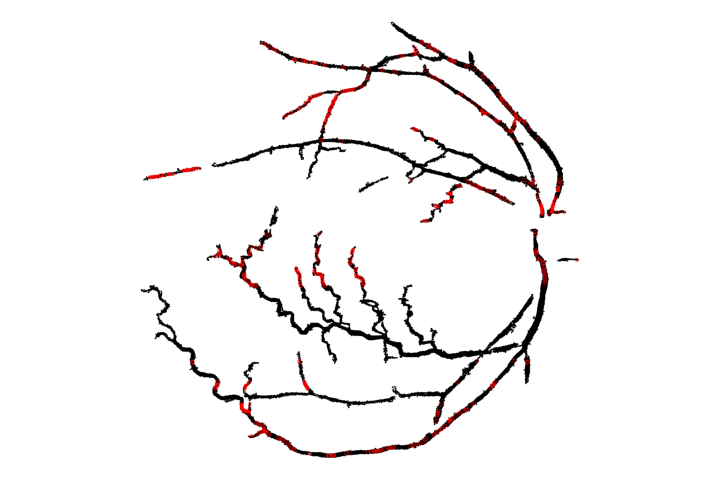

In [25]:
curvature_points = tv_processer.calculate_curvature_from_vectors(unit_vectors, curvature_threshold=np.pi/4)
marked_acute_image = tv_processer.mark_curvature_points(curvature_points, radius=5, color=(255, 0, 0))
plot_image(marked_acute_image)

## Validate TVProcesser with Example Lines

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line_aa
from skimage import morphology

from tv_processer import TVProcesser
from common import plot_image

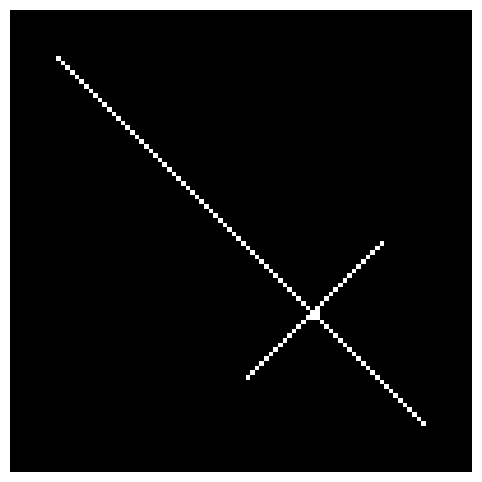

In [27]:
# Create a synthetic image with a straight line and a curve
synthetic_image = np.zeros((100, 100), dtype=np.uint8)

# Draw a straight line
rr, cc, val = line_aa(10, 10, 90, 90)
synthetic_image[rr, cc] = val * 255

# Draw a curve by connecting two lines at a sharp angle
rr, cc, val = line_aa(80, 50, 50, 80)
synthetic_image[rr, cc] = val * 255

# Skeletonize the synthetic image
synthetic_skeleton = morphology.skeletonize(synthetic_image > 0)

plot_image(synthetic_skeleton)

In [28]:
tv_processer = TVProcesser(synthetic_image)
unit_vectors = tv_processer.get_unit_vectors(synthetic_skeleton, 2)

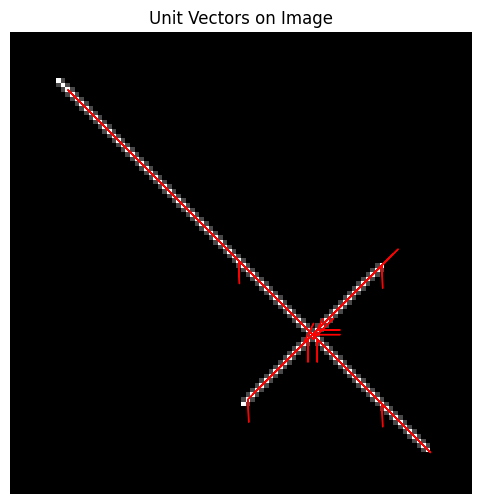

In [29]:
tv_processer.plot_unit_vectors(unit_vectors)

Marking points: 100%|██████████| 3/3 [00:00<00:00, 10800.78it/s]


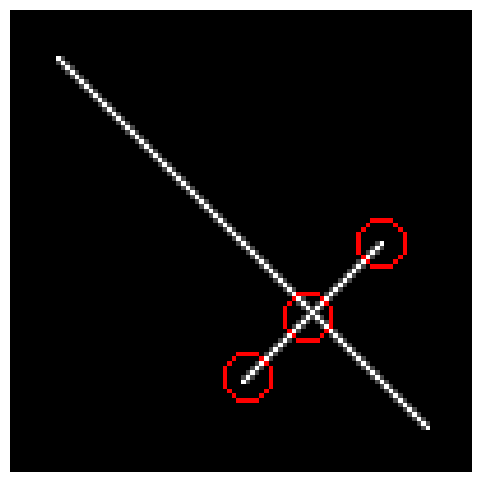

In [30]:
curvature_points = tv_processer.calculate_curvature_from_vectors(unit_vectors, curvature_threshold=np.pi/2)
marked_acute_image = tv_processer.mark_curvature_points(curvature_points, radius=5, color=(255, 0, 0))
plot_image(marked_acute_image)